In [1]:
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from tqdm import tqdm

In [2]:
good_matches_df = pd.DataFrame(
    [
        {"LEI": "HQD377W2YR662HK5JX27", "CIK": "0000001800"},
        {"LEI": "9C1X8XOOTYY2FNYTVH06", "CIK": "0000040533"},
        {"LEI": "3C7474T6CDKPR9K6YT90", "CIK": "0000040545"},
        {"LEI": "549300XMP3KDCKJXIU47", "CIK": "0000062709"},
        {"LEI": "549300ZFEEJ2IP5VME73", "CIK": "0000093751"},
        {"LEI": "WHENKOULSSK7WUM60H03", "CIK": "0000106640"},
        {"LEI": "PBJHNT51T5V6G5UQFV42", "CIK": "0000351569"},
        {"LEI": "529900E95812SYWMCE44", "CIK": "0000723612"},
        {"LEI": "ORQTRC074CWLT3DKHT41", "CIK": "0000740260"},
        {"LEI": "549300J4ZRR1SZF4ES33", "CIK": "0000783325"},
        {"LEI": "549300IGLYTZUK3PVP70", "CIK": "0000783325"},
        {"LEI": "FU4LY2G4933NH2E1CP29", "CIK": "0000796343"},
        {"LEI": "549300D3L3G0R4U4VT04", "CIK": "0000820313"},
        {"LEI": "549300LRGRD8XC9BTL66", "CIK": "0000851310"},
        {"LEI": "549300HWF93HB8BDM648", "CIK": "0000883237"},
        {"LEI": "784F5XWPLTWKTBV3E584", "CIK": "0000886982"},
        {"LEI": "549300VFZ8XJ9NUPU221", "CIK": "0001001250"},
        {"LEI": "SQL3F6CKNNBM3SQGHX24", "CIK": "0001020569"},
        {"LEI": "2T3D6M0JSY48PSZI1Q41", "CIK": "0001039684"},
        {"LEI": "P16VZZCKTJ5IONL6XE37", "CIK": "0001042729"},
        {"LEI": "5493000C01ZX7D35SD85", "CIK": "0001067983"},
        {"LEI": "549300UJLWOIWFDGB318", "CIK": "0001070081"},
        {"LEI": "549300VSMO9KYQWDND94", "CIK": "0001094285"},
        {"LEI": "54930073EK7NHVJF3D24", "CIK": "0001102432"},
        {"LEI": "549300DV9GIB88LZ5P30", "CIK": "0001103982"},
        {"LEI": "CUMYEZJOAF02RYZ1JJ85", "CIK": "0001126328"},
        {"LEI": "9695005J16R56PCL8N38", "CIK": "0001140536"},
        {"LEI": "549300WHC56FF48KL350", "CIK": "0001140536"},
        {"LEI": "529900EVVV534W8R0T32", "CIK": "0001234006"},
        {"LEI": "549300IH2S17MAIUCM32", "CIK": "0001273441"},
        {"LEI": "549300NPYMLM4NHTOF27", "CIK": "0001274494"},
        {"LEI": "MTLVN9N7JE8MIBIJ1H73", "CIK": "0001276187"},
        {"LEI": "549300D4549QKWETZ406", "CIK": "0001336917"},
        {"LEI": "549300NDDBVLJS24LD07", "CIK": "0001370755"},
        {"LEI": "549300YG7Z2BC73TCX59", "CIK": "0001403161"},
        {"LEI": "HL3H1H2BGXWVG3BSWR90", "CIK": "0001413329"},
        {"LEI": "724500M9BY5293JDF951", "CIK": "0001413447"},
        {"LEI": "5493007CT6ATBZ2L6826", "CIK": "0001433660"},
        {"LEI": "549300VDIGTMXUNT7H71", "CIK": "0001551182"},
        {"LEI": "5493005LXSLNF92BF097", "CIK": "0001572334"},
        {"LEI": "529900E7PUVK6BC8PE80", "CIK": "0001590364"},
        {"LEI": "549300TUSNXS3BFFML48", "CIK": "0001627014"},
        {"LEI": "549300CMHPBEY6VPOT75", "CIK": "0001674910"},
        {"LEI": "ISRPG12PN4EIEOEMW547", "CIK": "0001735707"},
        {"LEI": "549300GZKULIZ0WOW665", "CIK": "0001744489"},
        {"LEI": "2549006ALJE6NRO2Q503", "CIK": "0001764046"},
        {"LEI": "5493008G0Y8W4B2BWL04", "CIK": "0001825079"},
        {"LEI": "549300XR4L1D80AK4W76", "CIK": "0001834584"},
    ]
)

In [3]:
good_matches = pa.compute.binary_join_element_wise(
    pa.array(good_matches_df["LEI"]), pa.array(good_matches_df["CIK"]), ":"
)

In [4]:
cartesian_product = pq.ParquetFile("../cartesian-product.parquet")

In [5]:
good_indexes = []
for rg_index in tqdm(range(cartesian_product.metadata.num_row_groups)):
    lei_cik = cartesian_product.read_row_group(rg_index, ["LEI", "CIK"])
    (indexes,) = np.nonzero(
        pa.compute.is_in(
            pa.compute.binary_join_element_wise(lei_cik["LEI"], lei_cik["CIK"], ":"),
            good_matches,
        )
    )
    good_indexes.append(indexes)

100%|██████████| 22561/22561 [02:44<00:00, 137.23it/s]


In [6]:
good_df = {
    "name": [],
    "legal_address": [],
    "legal_city": [],
    "legal_state": [],
    "legal_zip": [],
    "hq_address": [],
    "hq_city": [],
    "hq_state": [],
    "hq_zip": [],
    "is_us": [],
}
for rg_index in tqdm(range(cartesian_product.metadata.num_row_groups)):
    if len(good_indexes[rg_index]) != 0:
        table = cartesian_product.read_row_group(rg_index)
        for key, value in good_df.items():
            value.extend(np.asarray(table[key])[good_indexes[rg_index]])

good_df = pd.DataFrame(good_df)

100%|██████████| 22561/22561 [00:00<00:00, 114154.23it/s]


In [7]:
good_df

,name,legal_address,legal_city,legal_state,legal_zip,hq_address,hq_city,hq_state,hq_zip,is_us
0,29,29,50,0,0,30,50,0,0,0
1,29,29,50,0,0,30,50,0,0,0
2,100,19,22,100,1,100,100,100,5,3
3,100,35,14,60,0,35,14,60,0,3
4,35,28,22,60,1,84,100,100,5,3
5,100,31,20,60,0,33,100,100,5,3
6,88,82,100,100,5,82,100,100,5,3
7,98,28,13,80,0,100,100,100,5,3
8,90,21,100,100,5,100,100,100,5,3
9,100,12,33,60,0,100,100,100,5,3


In [8]:
h_name = np.zeros(101, dtype=np.int64)
h_legal = np.zeros((101, 201), dtype=np.int64)
h_hq = np.zeros((101, 201), dtype=np.int64)

for rg_index in tqdm(range(cartesian_product.metadata.num_row_groups)):
    table = cartesian_product.read_row_group(
        rg_index,
        [
            "name",
            "legal_address",
            "legal_city",
            "legal_state",
            "hq_address",
            "hq_city",
            "hq_state",
        ],
    )
    np.add.at(
        h_name,
        np.asarray(table["name"]),
        1,
    )
    np.add.at(
        h_legal,
        (
            np.asarray(table["legal_address"]),
            np.asarray(table["legal_city"]).astype(np.uint8)
            + np.asarray(table["legal_state"]).astype(np.uint8),
        ),
        1,
    )
    np.add.at(
        h_hq,
        (
            np.asarray(table["hq_address"]),
            np.asarray(table["hq_city"]).astype(np.uint8)
            + np.asarray(table["hq_state"]).astype(np.uint8),
        ),
        1,
    )

100%|██████████| 22561/22561 [01:57<00:00, 191.39it/s]


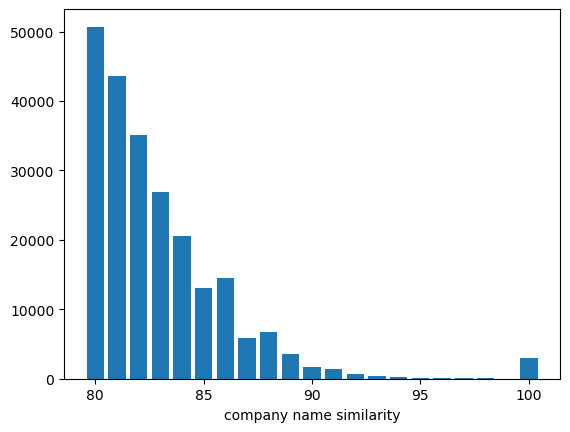

In [9]:
fig, ax = plt.subplots()

ax.bar(range(80, 101), h_name[80:])

ax.set_xlabel("company name similarity")

None

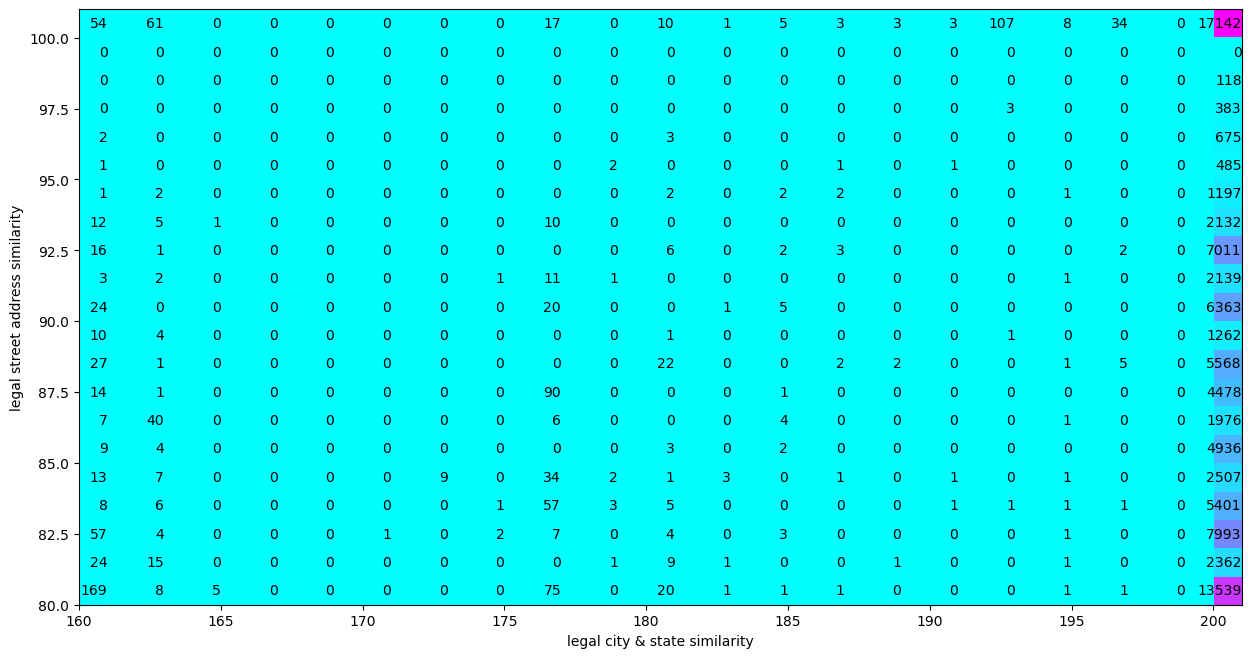

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.imshow(
    h_legal[80:101, 160:201],
    extent=(160, 201, 80, 101),
    cmap="cool",
    origin="lower",
    aspect=1,
)

for i in range(80, 101):
    for j in range(160, 201, 2):
        ax.text(j + 1, i + 0.5, h_legal[i, j], ha="right", va="center")

ax.set_xlabel("legal city & state similarity")
ax.set_ylabel("legal street address similarity")

None

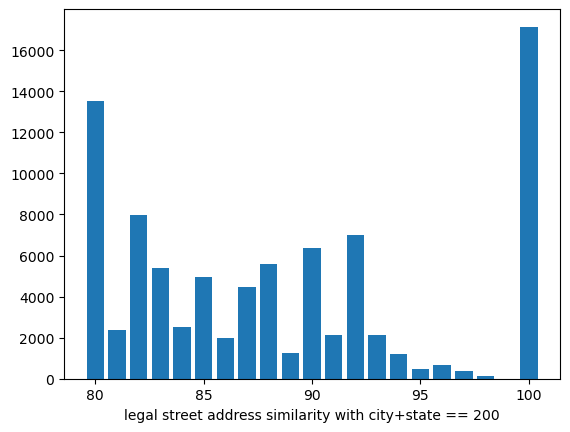

In [11]:
fig, ax = plt.subplots()

ax.bar(range(80, 101), h_legal[80:, 200])

ax.set_xlabel("legal street address similarity with city+state == 200")

None

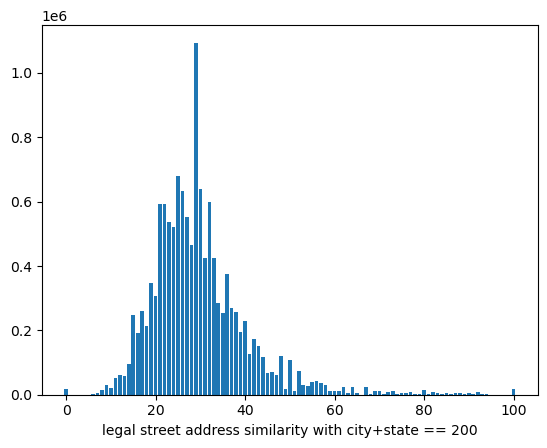

In [12]:
fig, ax = plt.subplots()

ax.bar(range(0, 101), h_legal[:, 200])

ax.set_xlabel("legal street address similarity with city+state == 200")

None

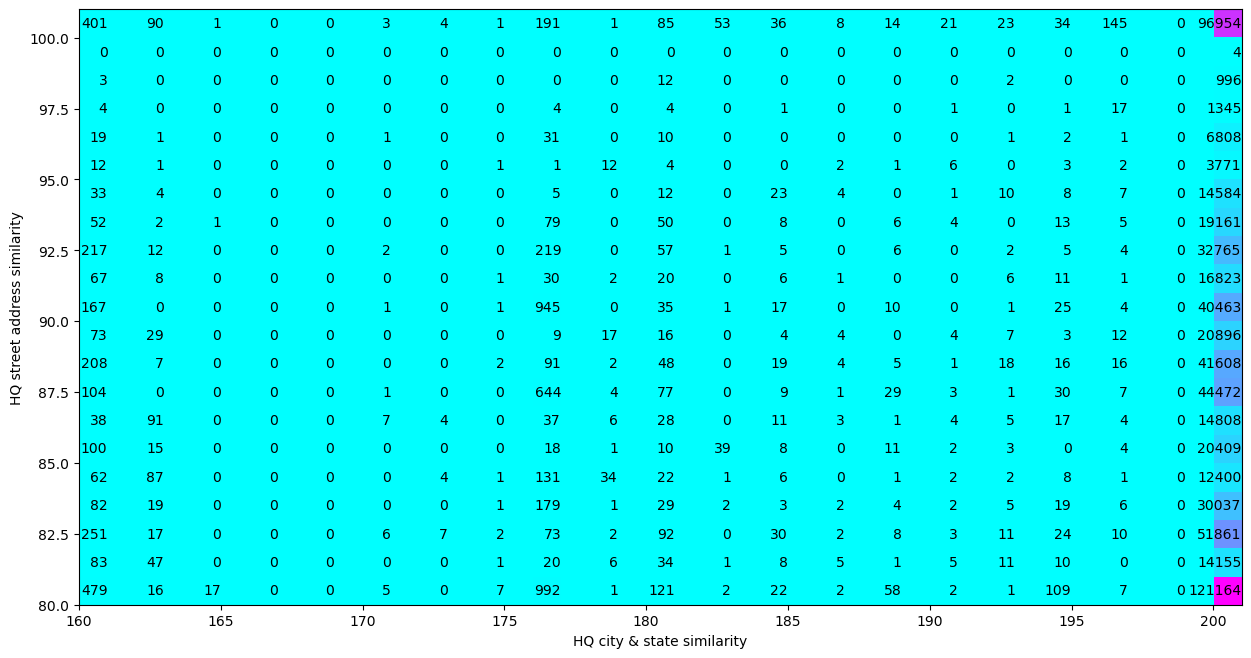

In [13]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.imshow(
    h_hq[80:101, 160:201],
    extent=(160, 201, 80, 101),
    cmap="cool",
    origin="lower",
    aspect=1,
)

for i in range(80, 101):
    for j in range(160, 201, 2):
        ax.text(j + 1, i + 0.5, h_hq[i, j], ha="right", va="center")

ax.set_xlabel("HQ city & state similarity")
ax.set_ylabel("HQ street address similarity")

None

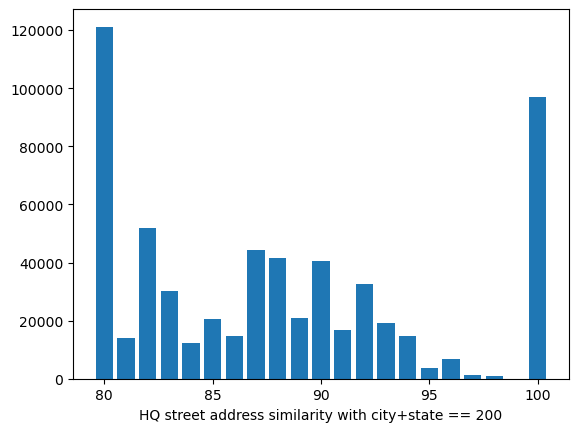

In [14]:
fig, ax = plt.subplots()

ax.bar(range(80, 101), h_hq[80:, 200])

ax.set_xlabel("HQ street address similarity with city+state == 200")

None

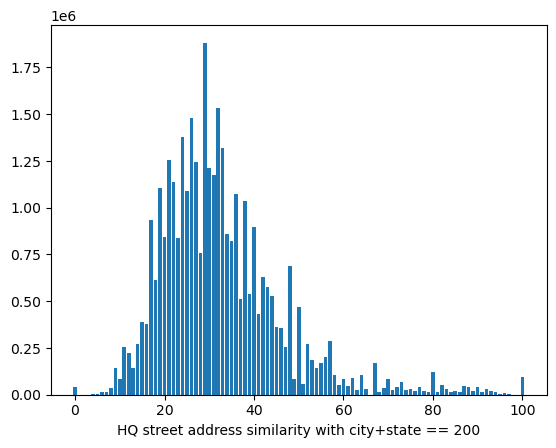

In [15]:
fig, ax = plt.subplots()

ax.bar(range(0, 101), h_hq[:, 200])

ax.set_xlabel("HQ street address similarity with city+state == 200")

None